In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [38]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [39]:
df['diffPassenger'] = df['Passengers'].diff()

In [41]:
df.head()

,Passengers,diffPassenger
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [42]:
df['diffPassenger'] = df['diffPassenger'].fillna(0.)

In [43]:
df.head()

,Passengers,diffPassenger
Month,,
1949-01-01,112,0.0
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [46]:
df['cumdiffPassenger'] =  112+df['diffPassenger'].cumsum()

In [56]:
df['Passengers_shift_one']= df['Passengers'].shift(1)
df['Passengers_shift_two']= df['Passengers'].shift(2)
df['Passengers_shift_three']= df['Passengers'].shift(3)
df['Passengers_shift_four']= df['Passengers'].shift(4)

In [57]:
df=df[['Passengers','Passengers_shift_one','Passengers_shift_two','Passengers_shift_three','Passengers_shift_four']]

In [64]:
df = df.dropna()
X =df[['Passengers_shift_one','Passengers_shift_two','Passengers_shift_three','Passengers_shift_four']]
Y = df['Passengers']

In [65]:
X.head()

,Passengers_shift_one,Passengers_shift_two,Passengers_shift_three,Passengers_shift_four
Month,,,,
1949-05-01,129.0,132.0,118.0,112.0
1949-06-01,121.0,129.0,132.0,118.0
1949-07-01,135.0,121.0,129.0,132.0
1949-08-01,148.0,135.0,121.0,129.0
1949-09-01,148.0,148.0,135.0,121.0


In [66]:
Y.head()

Month
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
Name: Passengers, dtype: int64

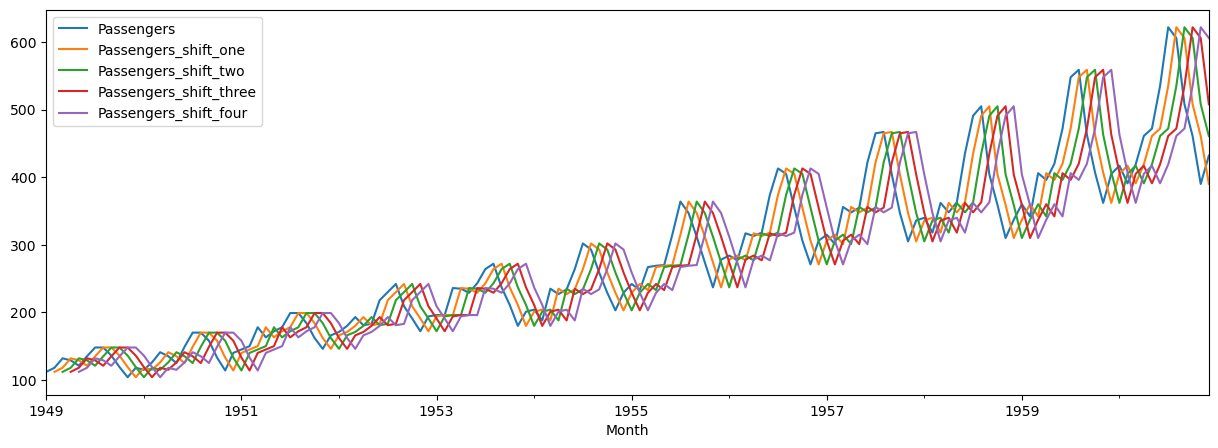

In [59]:
df.plot(figsize=(15, 5));

In [5]:
df['1stdiff'] = df['Passengers'].diff()

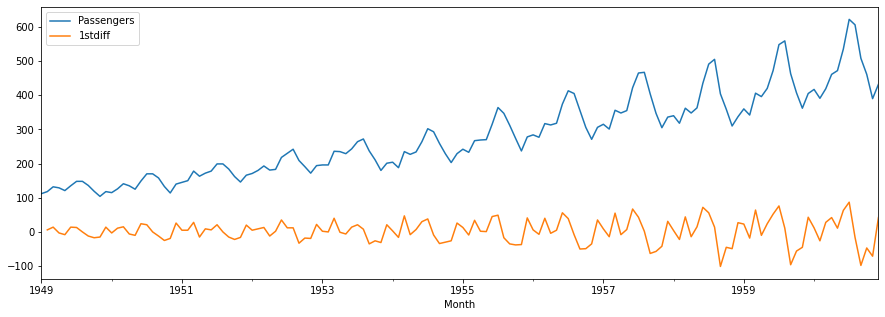

In [6]:
df.plot(figsize=(15, 5));

In [7]:
df['LogPassengers'] = np.log(df['Passengers'])

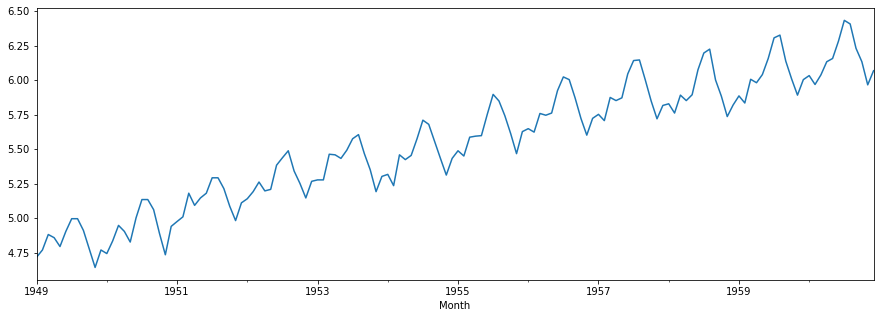

In [8]:
df['LogPassengers'].plot(figsize=(15, 5));

In [9]:
from statsmodels.tsa.arima.model import ARIMA

In [10]:
df.index.freq = 'MS'

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [11]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [12]:
arima = ARIMA(train['Passengers'], order=(1,0,0))

In [13]:
arima_result = arima.fit()

In [14]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(
    start=train.index[0], end=train.index[-1])

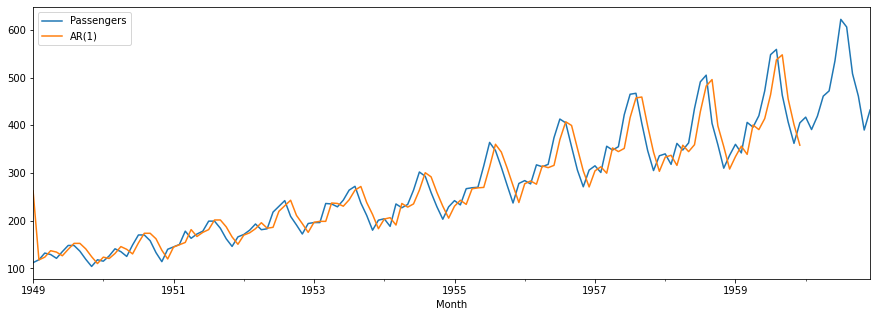

In [15]:
df[['Passengers', 'AR(1)']].plot(figsize=(15, 5));

In [16]:
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast

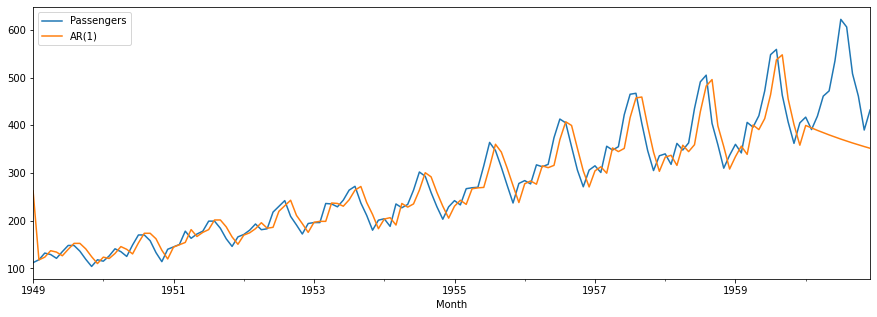

In [17]:
df[['Passengers', 'AR(1)']].plot(figsize=(15, 5));

In [18]:
# Explore prediction result further
type(prediction_result)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [19]:
# Confidence interval
prediction_result.conf_int()

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826171,478.809354
1960-03-01,287.732168,490.829380
1960-04-01,269.338255,499.534230
1960-05-01,253.432283,506.121348
1960-06-01,239.373402,511.217437
1960-07-01,226.768868,515.201639
1960-08-01,215.354569,518.324977
1960-09-01,204.941150,520.764225
1960-10-01,195.386337,522.649550


In [20]:
def plot_fit_and_forecast(result):
  fig, ax = plt.subplots(figsize=(15, 5))
  ax.plot(df['Passengers'], label='data')

  # plot the curve fitted on train set
  train_pred = result.fittedvalues
  ax.plot(train.index, train_pred, color='green', label='fitted')

  # forecast the test set
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int['lower Passengers'], conf_int['upper Passengers']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
  ax.legend()

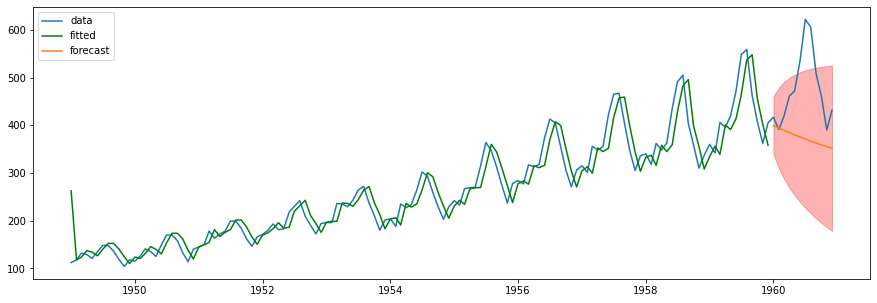

In [21]:
plot_fit_and_forecast(arima_result)

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


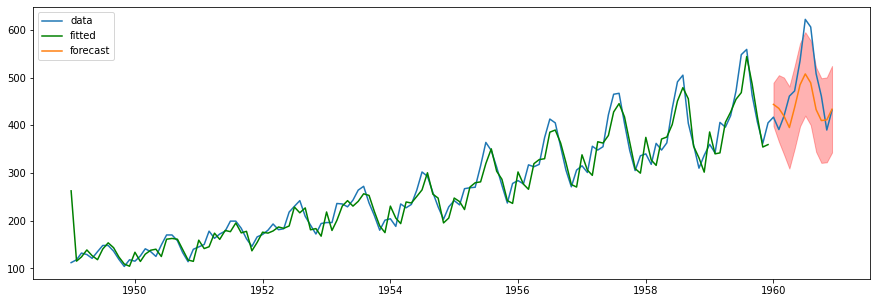

In [22]:
arima = ARIMA(train['Passengers'], order=(10,0,0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


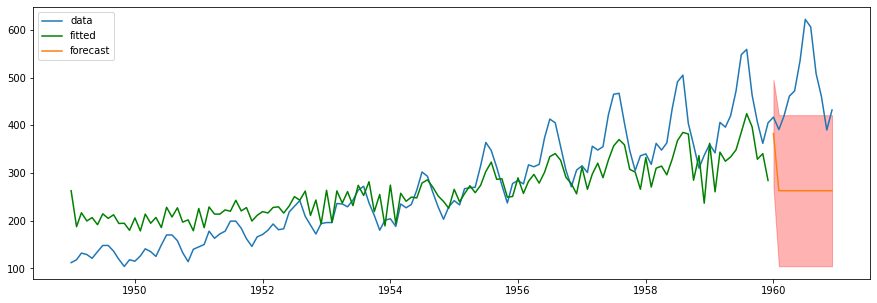

In [23]:
arima = ARIMA(train['Passengers'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

In [24]:
df['Log1stDiff'] = df['LogPassengers'].diff()

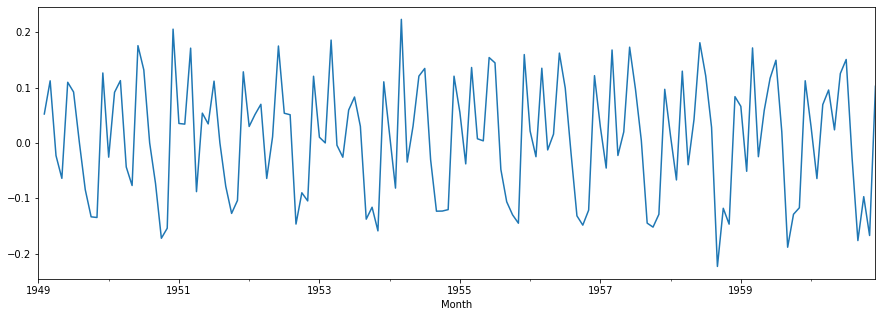

In [25]:
df['Log1stDiff'].plot(figsize=(15, 5));

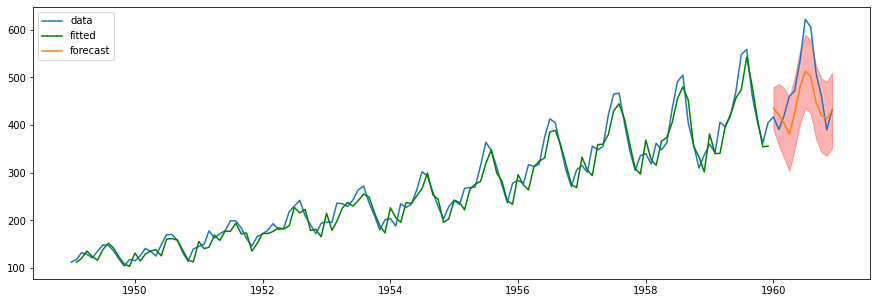

In [26]:
arima = ARIMA(train['Passengers'], order=(8,1,1))
arima_result_811 = arima.fit()

def plot_fit_and_forecast_int(result, d, col='Passengers'):
  fig, ax = plt.subplots(figsize=(15, 5))
  ax.plot(df[col], label='data')

  # plot the curve fitted on train set
  train_pred = result.predict(start=train.index[d], end=train.index[-1])

  ax.plot(train.index[d:], train_pred, color='green', label='fitted')

  # forecast the test set
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
  ax.legend()

plot_fit_and_forecast_int(arima_result_811, 1)

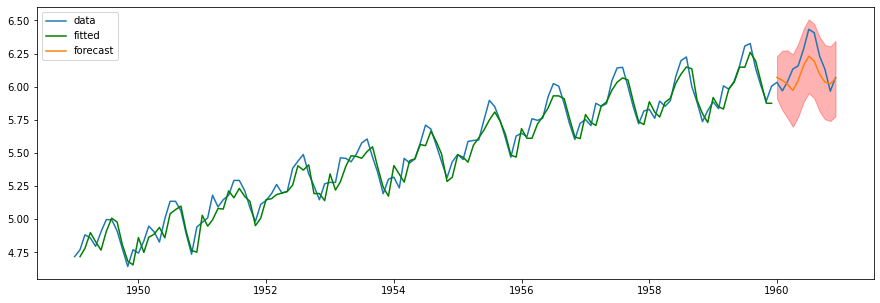

In [27]:
arima = ARIMA(train['LogPassengers'], order=(8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


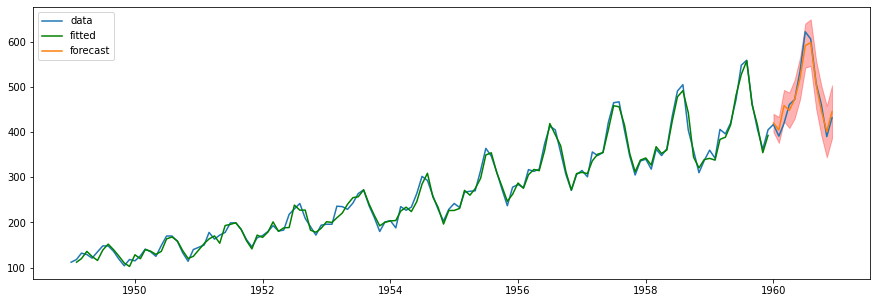

In [28]:
arima = ARIMA(train['Passengers'], order=(12,1,0))
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210, 1, col='Passengers')

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


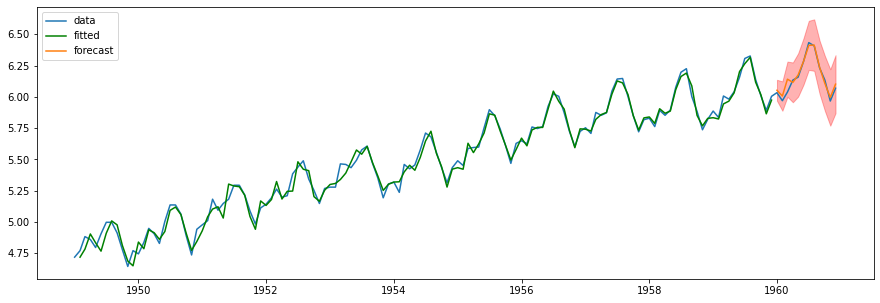

In [29]:
arima = ARIMA(train['LogPassengers'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')

In [30]:
def rmse(result, is_logged):
  forecast = result.forecast(Ntest)
  if is_logged:
    forecast = np.exp(forecast)
  
  t = test['Passengers']
  y = forecast
  return np.sqrt(np.mean((t - y)**2))

In [31]:
print("ARIMA(8,1,1):", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12,1,0):", rmse(arima_result_1210, False))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))

ARIMA(8,1,1): 59.064584006816226
ARIMA(8,1,1) logged: 61.602324847818736
ARIMA(12,1,0): 17.49288498260966
ARIMA(12,1,0) logged: 16.207862726844393
